In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import zipfile
import matplotlib.pyplot as plt

arquivo_zip = 'dataset_RM_cerebral.zip'
pasta_destino = './dados_extraidos'

if os.path.exists(arquivo_zip):
    if not os.path.exists(pasta_destino):
        print("Descompactando imagens...")
        with zipfile.ZipFile(arquivo_zip, 'r') as zip_ref:
            zip_ref.extractall(pasta_destino)
        print("Descompactação concluída!")
    else:
        print("Pasta de dados já existe. Pulando descompactação.")
else:
    print(f"ERRO: Não encontrei {arquivo_zip}. Faça o upload primeiro!")

diretorio_imagens = os.path.join(pasta_destino, 'dataset_RM_cerebral')

batch_size = 32
img_size = (224, 224)

print("Carregando datasets...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    diretorio_imagens,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    diretorio_imagens,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='binary'
)

train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

print("Baixando/Carregando MobileNetV2...")
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False

model = models.Sequential([
    layers.Rescaling(1./127.5, offset=-1, input_shape=(224, 224, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("\nTUDO PRONTO!")

Descompactando imagens...
Descompactação concluída!
Carregando datasets...
Found 2870 files belonging to 2 classes.
Using 2296 files for training.
Found 2870 files belonging to 2 classes.
Using 574 files for validation.
Baixando/Carregando MobileNetV2...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

TUDO PRONTO!


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


--- Balanceamento Automático Ativado ---
Peso para 'Normal': 3.63 (A IA vai dar 6.3x mais atenção a elas)
Peso para 'Tumor': 0.58

Iniciando treinamento equilibrado por 15 épocas...
Epoch 1/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 53s 465ms/step - accuracy: 0.7683 - loss: 0.5459 - val_accuracy: 0.9199 - val_loss: 0.2777
Epoch 2/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9320 - loss: 0.2272 - val_accuracy: 0.9338 - val_loss: 0.2401
Epoch 3/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9392 - loss: 0.1911 - val_accuracy: 0.9408 - val_loss: 0.2075
Epoch 4/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9533 - loss: 0.1497 - val_accuracy: 0.9530 - val_loss: 0.1753
Epoch 5/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9581 - loss: 0.1414 - val_accuracy: 0.9512 - val_loss: 0.1739
Epoch 6/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9545 - loss: 0.1266 - val_accuracy: 0.9582 - val_loss: 0.1505
Epoch 7/15
72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - a

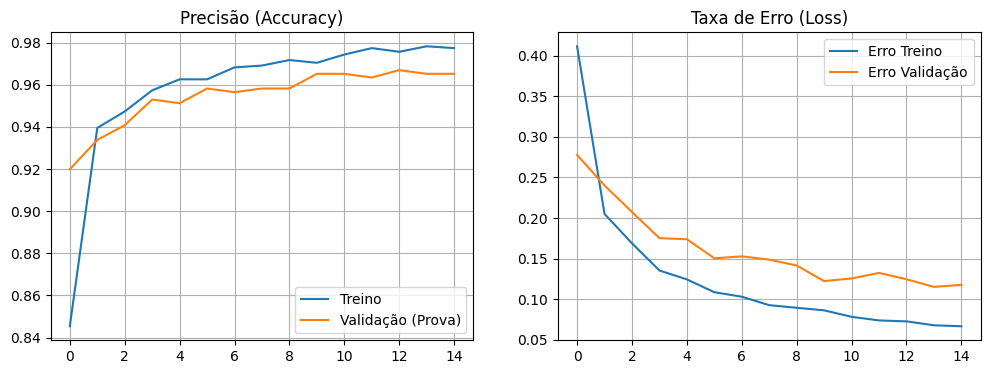


Precisão final na prova: 96.52%


In [4]:
total_tumor = 2475
total_normal = 395
total = total_tumor + total_normal

peso_normal = (1 / total_normal) * (total / 2.0)
peso_tumor = (1 / total_tumor) * (total / 2.0)

class_weights = {0: peso_normal, 1: peso_tumor}

print(f"--- Balanceamento Automático Ativado ---")
print(f"Peso para 'Normal': {peso_normal:.2f} (A IA vai dar {peso_normal/peso_tumor:.1f}x mais atenção a elas)")
print(f"Peso para 'Tumor': {peso_tumor:.2f}")

EPOCAS = 15

print(f"\nIniciando treinamento equilibrado por {EPOCAS} épocas...")

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCAS,
    class_weight=class_weights
)

import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCAS)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Treino')
plt.plot(epochs_range, val_acc, label='Validação (Prova)')
plt.legend(loc='lower right')
plt.title('Precisão (Accuracy)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Erro Treino')
plt.plot(epochs_range, val_loss, label='Erro Validação')
plt.legend(loc='upper right')
plt.title('Taxa de Erro (Loss)')
plt.grid(True)
plt.show()

print(f"\nPrecisão final na prova: {val_acc[-1]*100:.2f}%")

In [ ]:
print("Salvando o modelo...")

model.save('modelo_tumor_final.keras')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('modelo_tumor_final.tflite', 'wb') as f:
    f.write(tflite_model)

print("\nCONCLUÍDO!")
print("Arquivo 'modelo_tumor_final.tflite' disponível para baixar")

Salvando o modelo...
Saved artifact at '/tmp/tmpdjpf7hl_'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  133562811317136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133562751872912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133562751875024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133562751874640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133562751872528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133562751872720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133562751875216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133562751875984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133562751875600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133562751873104: TensorSpec(shape=(), dtype=tf.resource, na